Deep Learning Recurrent Neural Network

Development of a recurrent network to solve a prediction problem for time series. The feature to be predicted is the weakly sales in 3 weeks.

The notebook is divided in sections with the following structure:
1. Imports, declarations and configuration
2. Dataset
3. Testing </br>
    Base Model</br>
    Optimizer Selection</br>
    Test length</br>
    Complex models</br>
    Regularization</br>
    Optimizing learning rate</br>
4. Results</br>

## 1. Imports, declarations and configuration

In this section we define the necessary imports, declarations and configuration to run the application. 

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [2]:
# Verify that GPU is active
gpu_active = tf.config.list_physical_devices('GPU')

if (len(gpu_active) == 0):
    print("NO GPU ACTIVE!!!")
else:
    print("Using GPU")

Using GPU


In [3]:
# The only parameter that can be modified for the data preparation method is the length of the sequences to be generated
length_value = 8

# If activated test the simple models
test_simple = False
# If activated test the optimizers
test_optimizer = False
# If activated test different lengths for the sequence
test_length = False
# If activated test the complex models
test_complex = False
# If activated test the regularization and optimizations
test_reg = False

## 2. Dataset

In this section we load the dataset for training and validation with the provided functions. </br>

In [4]:
#Returns a numpy array with size nrows x ncolumns-1. nrows and ncolums are the rows and columns of the dataset
#the Date column is skipped (ncolumns-1)
def readData(fname):
    with open(fname) as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    header = lines[0].split(",")
    lines = lines[1:] 
    #print(header) 
    #print("Data rows: ", len(lines))

    rawData = np.zeros((len(lines), len(header)-1)) #skip the Date column

    for i, aLine in enumerate(lines):       
        splittedLine = aLine.split(",")[:]
        rawData[i, 0] = splittedLine[0]
        rawData[i, 1:] = [float(x) for x in splittedLine[2:]] 

    return rawData

In [5]:
#Returns the train and test data, normalized. It also returns the standard deviation of Weekly_Sales
#Each list has a size equal to the number of stores
#For each store there is a list of size trainNSaples (testNSamples) x nColums-1 (the store id is skipped)
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
def splitTrainTest(rawData, testPercent):

    listStore = np.unique(rawData[:, 0])
    trainNSamples = np.zeros(len(listStore))
    
    for i, storeId in enumerate(listStore):
        trainNSamples[i] = np.count_nonzero(rawData[:, 0] == storeId)
    trainNSamples = np.floor((1-testPercent) *  trainNSamples)

    tmpTrain = np.zeros((int(np.sum(trainNSamples)), len(rawData[0])))

    store = -1
    counter = 0
    counterTrain = 0
    storeDict = dict(zip(listStore, trainNSamples))
    for i, aLine in enumerate(rawData):
        if store != aLine[0]:
            store = int(aLine[0])
            counter = 0
        if(counter < storeDict.get(store)):
            tmpTrain[counterTrain] = rawData[i][:]
            counterTrain += 1
            counter += 1

    meanData = tmpTrain.mean(axis=0)
    stdData = tmpTrain.std(axis=0)
    rawNormData = (rawData - meanData) / stdData

    allTrain = list()
    allTest = list()
    store = -1
    counter = 0
    for i, aLine in enumerate(rawNormData):
        splittedLine = [float(x) for x in aLine[1:]] #skip store id
        if store != rawData[i][0]:
            if i != 0:
                allTrain.append(storeDataTrain)
                allTest.append(storeDataTest)
            store = int(rawData[i][0])
            storeDataTrain = list()
            storeDataTest = list()
            counter = 0

        if(counter < storeDict.get(store)):
            storeDataTrain.append(splittedLine)
            counter += 1
        else:
            storeDataTest.append(splittedLine)

        if i == len(rawNormData)-1:
            allTrain.append(storeDataTrain)
            allTest.append(storeDataTest)

    return allTrain, allTest, stdData[1] #std of wSales

In [6]:
#generates a time series given the input and output data, the sequence length and the batch size
#seqLength is the number of weeks (observations) of data to be used as input
#the target will be the weekly sales in 2 weeks
def generateTimeSeries(data, wSales, seqLength, batchSize):   
    sampling_rate = 1 #keep all the data points 
    weeksInAdvance = 3
    delay = sampling_rate * (seqLength + weeksInAdvance - 1) #the target will be the weekly sales in 2 weeks
    
    dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets=wSales[delay:],
        sampling_rate=sampling_rate,
        sequence_length=seqLength,
        shuffle=True,
        batch_size=batchSize,
        start_index=0)
    
    return dataset

In [7]:
def printTimeSeriesList(theList):
    print('list length', len(theList))
    print('First element')
    input, target = theList[0]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])
    print('Last element')
    input, target = theList[-1]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])

In [8]:
#returns the training and test time series
#it also returns the standard deviation of Weekly_Sales, and the number of input features
def generateTrainTestData(fileName, testPercent, seqLength, batchSize):
    rawData = readData(os.path.join(fileName))
    allTrain, allTest, stdSales = splitTrainTest(rawData, testPercent)
    
    for i in range(len(allTrain)):
        tmp_train = generateTimeSeries(np.array(allTrain[i]), np.array(allTrain[i])[:,0], seqLength, batchSize)
        tmp_test = generateTimeSeries(np.array(allTest[i]), np.array(allTest[i])[:,0], seqLength, batchSize)

        if i == 0:
            train_dataset = tmp_train
            test_dataset = tmp_test
        else:
            train_dataset = train_dataset.concatenate(tmp_train)
            test_dataset = test_dataset.concatenate(tmp_test)
    
    return train_dataset, test_dataset, stdSales, np.shape(allTrain)[2]

In [9]:
#generateTrainTestData(fileName, testPercent, seqLength, batchSize):
#trainData, testData: each element comes from keras.utils.timeseries_dataset_from_array, i.e., is a time series
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment

testPercent = 0.2
seqLength = length_value
batchSize = 1
trainData, testData, stdSales, nFeatures = generateTrainTestData("dataset/walmart-sales-dataset-of-45stores.csv",
    testPercent, seqLength, batchSize) 

In [10]:
print("Training rows: ", len(trainData))
print("Test rows:", len(testData))
print("Standard deviation:", stdSales)
print(nFeatures)

Training rows:  4365
Test rows: 540
Standard deviation: 571854.7800576452
6


In [11]:
print(type(trainData))

tensorflow.python.data.ops.dataset_ops.ConcatenateDataset

In [12]:
for samples, targets in trainData:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (1, 8, 6)
targets shape: (1,)


## 3. Testing

In the testing section we experiment with different length, optimizers, models, hyperparameter and regularization to define our final model. We stored the testing results graph of the training and validation metrics in the images folder and the executed models in the models folder. Once we finish with the testing in each section, we disable it with the use of variables so we don't run it again every time we execute the notebook.

Do not use GridSearch or RandomSearch methods because the time it takes to run only one test is large enough. Using this kind of testing takes hours or in some of our tests, exhaust the resources of the computer.

### Supplementary functions and default configuration
Supplementary functions to plot the data and return some predefined models. Default defined optimizers.

In [13]:
# Function to get the callbacks for the test of the models
def get_callbacks(name):
    # This is to save computational power as a 15 epoch value without improvement we know is not going to get better
    return [EarlyStopping(monitor='val_loss', patience=15, verbose=1),
            # Save only the best model
            keras.callbacks.ModelCheckpoint(filepath="models/" + name + ".keras",save_best_only=True,monitor="val_loss", verbose=1)
            ]

In [14]:
# Function to print the results of the training
def print_plot(name, history, evaluate):
    fig, axs = plt.subplots(1,1)
    fig.suptitle(name)
    fig.set_figwidth(10)
    axs.plot(history.history['loss'])
    axs.plot(history.history['val_loss'])
    axs.set_title('Best metrics: ' + evaluate)
    axs.set_xlabel('Epochs')
    axs.legend(['MAE', 'Val_MAE'])
    axs.set_ylim([0, 0.6])
    plt.savefig('images/' + name + '.png')
    plt.show()

In [15]:
# Function to get the basic model
def get_base_model():
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.GRU(16, return_sequences=True)(inputs)
    x = layers.GRU(16)(x)
    outputs = layers.Dense(1)(x)
    
    return keras.Model(inputs, outputs)

In [16]:
# Function to get the best optimizer (obtained in the test optimizer section)
def get_optimizer():
    return optimizers.Adamax(learning_rate=0.001)

### Base models

In this subsection we start experiment with some basic models.

In [17]:
if test_simple == True:
    name = 'SimpleDense'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.Flatten()(inputs)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

For obtaining the real MAE metrics we need to denormalize by multiplying by the standard deviation.

In [18]:
if test_simple == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

When we run the model, we save the images and the model in disk so we can use the model later if we need it and to show the result of the training in a markdown cell. This way, we don't need to rerun the cell to show the results.

![](images/SimpleDense.png)

As expected, we can see that the results with this simple model is not what we are looking for as its far from the 68.000 threshold, and that's why we will proceed to build more complex models based in RNN layers that could effectively learn the patterns of our sequence data. </br>

**SimpleRNN Model**

In [19]:
if test_simple == True:
    name = 'SimpleRNN'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.SimpleRNN(16, return_sequences=True)(inputs)
    x = layers.SimpleRNN(16)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [20]:
if test_simple == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

As we can see, the results are not better that the ones obtained with the dense model.

![](images/SimpleRNN.png)

**SimpleGRU**

In [21]:
if test_simple == True:
    name = 'SimpleGRU'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.GRU(16, return_sequences=True)(inputs)
    x = layers.GRU(16)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [22]:
if test_simple == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

We can see that the metrics really improve compared to the Dense and SimpleRNN models.

![](images/SimpleGRU.png)

**SimpleLSTM**

In [23]:
if test_simple == True:
    name = 'SimpleLSTM'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.LSTM(16, return_sequences=True)(inputs)
    x = layers.LSTM(16)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [24]:
if test_simple == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

We can see that the results are similar to the GRU model, variating only in a 0.3 MAE for worse. We decide to keep using GRU as is a simpler and faster layer to train.

![](images/SimpleLSTM.png)

**SimpleBidireccional** </br>
In general bidirectional layers are not recommended in problems where the chronological processing is important to the success of the approach.

In [25]:
if test_simple == True:
    name = 'SimpleBidireccional'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(inputs)
    x = layers.Bidirectional(layers.LSTM(16))(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [26]:
if test_simple == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

As expected, the result of this model are worse that the ones in the GRU and LSTM model.

![](images/SimpleBidireccional.png)

As we saw the best results were achieved by the GRU and LSTM networks. We decided to focus on optimizing the GRU network to improve its performance as it has a faster time for training and a better metric that the LSTM. So for the rest of the work we continued the GRU network to explore various optimizations and try to obtain better results.

### Optimizer selection

In this sub section we determinate which optimizer to use. 

In [27]:
# Instance the four optimizers
if test_optimizer == True:
    opt_names = ["RMSprop","adam","Adamax","SGD"]
    opt_values = [optimizers.RMSprop(learning_rate=0.001),optimizers.Adam(learning_rate=0.001), optimizers.Adamax(learning_rate=0.001),optimizers.SGD(learning_rate=0.01)]
    test_history= []

In [28]:
# Train the models
if test_optimizer == True:
    for i in range(0,len(opt_names)):
        model = get_base_model()

        model.compile(optimizer=opt_values[i], loss="mae", metrics=["mae"])
        print("Testing optimizer:",opt_names[i])
        
        test_history.append(model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(opt_names[i])))

In [29]:
# Generate the results
if test_optimizer == True:
    for i in range(0,len(opt_names)):
        model = keras.models.load_model("models/" + opt_names[i] + ".keras") 
        res = model.evaluate(testData)[1]
        print_plot(opt_names[i], test_history[i], f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

![](images/RMSprop.png)

![](images/adam.png)

![](images/Adamax.png)

![](images/SGD.png)

As we can see in the four plots shown before, Adamax optimizer was the one with the best results, that's why we will use it for the rest of the work. Other alternative could by Adam (same family of optimizers that Adamax), but we consider that the metrics and the number of epochs obtained by the Adamax optimizer are better.

### Test Lenghts </br>

In this sub section we try different sizes of the length.


The sequence length hyperparameter represents the historical step (weekly data) that will be used as inputs values to the model for prediction. It determines the period of time for one training sample in the dataset. By changing the sequence length, the method generateTrainTestData will generate different datasets with different training data, each having the specific number of weeks for training, but for the target it will always be the number of sales in 3 weeks after the last week of the sequence.

In [30]:
# Declare the sequence to test
if test_length == True:
    opt_names = ["length_2","length_4","length_7","length_8","length_9","length_10","length_11","length_12","length_13"]
    opt_values = [2,4,7,8,9,10,11,12,13]
    test_history= []
    test_data = []

In [31]:
if test_length == True:
    test_values = [2,4,7,8,9,10,11,12,13,14]
    for i in range(0,len(test_values)):   
        seqLength = test_values[i]
        trainData, testData, stdSales, nFeatures = generateTrainTestData("dataset/walmart-sales-dataset-of-45stores.csv",
            testPercent, seqLength, batchSize)

        print('Length: ' + str(test_values[i]), ' - Train: ' + str(len(trainData)), ' - Test: ' + str(len(testData)))

**Data analysis**</br>
Length: 2  - Train: 4905  - Test: 1080</br>
Length: 4  - Train: 4725  - Test: 900</br>
Length: 7  - Train: 4455  - Test: 630</br>
Length: 8  - Train: 4365  - Test: 540</br>
Length: 9  - Train: 4275  - Test: 450</br>
Length: 10  - Train: 4185  - Test: 360</br>
Length: 11  - Train: 4095  - Test: 270</br>
Length: 12  - Train: 4005  - Test: 180</br>
Length: 13  - Train: 3915  - Test: 90</br>
Length: 14  - Train: 3825  - Test: 0</br>

As we can see while increasing the number of sequences, the number of rows available for training will decrease. We will have more information for one sample but less data rows. For length 14, the number of rows in the test set will be zero, so it does not make sense keep testing after this value.

In [32]:
# Train the models
if test_length == True:
    for i in range(0,len(opt_names)):
        seqLength = opt_values[i]
        trainData, testData, stdSales, nFeatures = generateTrainTestData("dataset/walmart-sales-dataset-of-45stores.csv",
            testPercent, seqLength, batchSize) 

        # Save to use latter in evaluation
        test_data.append(testData)
        model = get_base_model()

        model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
        test_history.append(model.fit(trainData, validation_data=testData, epochs=120, callbacks=get_callbacks(opt_names[i])))

In [33]:
# Generate the results
if test_length == True:
    for i in range(0,len(opt_names)):
        model = keras.models.load_model("models/" + opt_names[i] + ".keras") 
        res = model.evaluate(testData[i])[1]
        print_plot(opt_names[i], test_history[i], f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")


![](images/length_2.png)

![](images/length_4.png)

![](images/length_7.png)

![](images/length_8.png)

![](images/length_9.png)

![](images/length_10.png)

![](images/length_11.png)

![](images/length_12.png)

![](images/length_13.png)

In the training results of the models we can see that some of the plots show that the validation data is better predicted that the training data. It is not common for the validation metrics to be consistently better than the training metrics as the model is adjusted on the training data and should be better at predicting it compared to the validation data. Some reasons that could lead to this is the use of data augmentation techniques (not this case), regularization techniques (not this case) and small datasets (as we see before, the test set is smaller as the length increases).

For this reason, even if the lengths 9,11,12,13 give better final mae results, we decide to keep using length=8 as it has a more stable training/validation curve.

### Complex models

In this subsection we try more complex models using our SimpleGRU as base for the new models.

In [34]:
if test_complex == True:
    name = 'simpleGRUDense_seq_' + str(length_value)
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.GRU(16, return_sequences=True)(inputs)
    x = layers.GRU(16)(x)
    x = layers.Dense(32)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [35]:
if test_complex == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

As we can see in the plot, the results where not better that the ones we get from our SimpleGRU model.

![](images/simpleGRUDense_seq_8.png)

In [36]:
if test_complex == True:
    name = 'TripleGRU_seq_' + str(length_value)
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.GRU(16, return_sequences=True)(inputs)
    x = layers.GRU(16, return_sequences=True)(x)
    x = layers.GRU(16)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [37]:
if test_complex == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

As we can see in the plot, the results where not better that the ones we get from our SimpleGRU model.

![](images/TripleGRU_seq_8.png)

In [38]:
if test_complex == True:
    name = 'SimpleGRU32'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.GRU(16, return_sequences=True)(inputs)
    x = layers.GRU(32)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [39]:
if test_complex == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

As we can see, this model improves the previous results to a value of 56298.53

![](images/simpleGRU32.png)

After observing that increasing the number of units has led to better results, we decided to apply this strategy for the next model. We constructed a model with two consecutive GRU layers where the first layer has 32 units and the second has 64 units.

In [ ]:
if test_complex == True:
    name = 'SimpleGRU64'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.GRU(32, return_sequences=True)(inputs)
    x = layers.GRU(64)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [ ]:
if test_complex == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

As we can see in the plot, the results where not better that the ones we get from our previous model with a layer of 16 and other of 32.

![](images/simpleGRU64.png)

The best model from this section was the one containing two GRU layers, one of 16 units and other of 32 units, so for the regularization and learning rate optimization sections we will continue with this one.

### Regularization

In this section we try different regularization techniques to improve the results of our model.

In [40]:
if test_reg == True:
    name = 'SimpleGRU32_Dropout'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.GRU(16, dropout=0.2 , recurrent_dropout=0.2,return_sequences=True)(inputs)
    x = layers.GRU(32, dropout=0.2 , recurrent_dropout=0.2)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [41]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

The results of our model do not improve adding the dropout techniques. 

![](images/SimpleGRU32_Dropout.png)

In [ ]:
if test_reg == True:
    name = 'SimpleGRU32_recdropout'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.GRU(16, recurrent_dropout=0.2,return_sequences=True)(inputs)
    x = layers.GRU(32, recurrent_dropout=0.2)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [ ]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

The results of our model do not improve adding only the recurrent dropout technique. 

![](images/SimpleGRU32_recdropout.png)

In [42]:
if test_reg == True:
    name = 'simpleGRU32_Norm'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.GRU(16, return_sequences=True)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.GRU(32)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [43]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

The result of the normalization are so out of range that they are not display in the plot, so we discard its use.

![](images/simpleGRU32_Norm.png)

For our next test, we try with weight decay, we use only L2 regularization as it gives us the best results in previous iterations. Other possible options could be L1 and the combination of L1 and L2.

In [44]:
if test_reg == True:
    name = 'SimpleGRU32_L2'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.GRU(16, kernel_regularizer=regularizers.l2(0.01),return_sequences=True)(inputs)
    x = layers.GRU(32, kernel_regularizer=regularizers.l2(0.01))(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [45]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

The results of our model do not improve adding the L2 regularization technique. 

![](images/simpleGRU32_L2.png)

In [46]:
if test_reg == True:
    # Add a GRU layer with dropout and L2 regularization
    name = 'SimpleGRU_DropoutL2'
    inputs = keras.Input(shape=(seqLength, nFeatures))
    x = layers.GRU(16, dropout=0.2 , recurrent_dropout=0.2,kernel_regularizer=regularizers.l2(0.01),return_sequences=True)(inputs)
    x = layers.GRU(32, dropout=0.2 , recurrent_dropout=0.2,kernel_regularizer=regularizers.l2(0.01))(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(optimizer=get_optimizer(), loss="mae", metrics=["mae"])
    history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

In [47]:
if test_reg == True:
    model = keras.models.load_model("models/" + name + ".keras") 
    res = model.evaluate(testData)[1]

    print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

The results of our model do not improve with the combination of dropout and L2 techniques. 

![](images/simpleGRU32_DropoutL2.png)

As we seen in this section, non of the regularization techniques that we use give a better result that our previous SimpleGRU32 model. This could mean that the model have data quality issues, where the performance may be limited by issues with the quality or quantity of your data. 
We will use in the optimizing learning rate section the model that we already have from our complex model testing section.

### Optimizing learning rate

In this subsection we do the fine tuning of the best model. 

In [63]:
name = "FinalModel_lr00001"
model = keras.models.load_model("models/SimpleGRU32.keras") 

optimizer = get_optimizer()
optimizer.learningrate=0.00001

model.compile(optimizer=optimizer, loss="mae", metrics=["mae"])
history = model.fit(trainData, validation_data=testData, epochs=100, callbacks=get_callbacks(name))

Epoch 1/100
4355/4365 [============================>.] - ETA: 0s - loss: 0.0893 - mae: 0.0893
Epoch 1: val_loss improved from inf to 0.10195, saving model to models\FinalModel_lr00001.keras
4365/4365 [==============================] - 31s 6ms/step - loss: 0.0893 - mae: 0.0893 - val_loss: 0.1019 - val_mae: 0.1019
Epoch 2/100
4355/4365 [============================>.] - ETA: 0s - loss: 0.0901 - mae: 0.0901
Epoch 2: val_loss did not improve from 0.10195
4365/4365 [==============================] - 25s 6ms/step - loss: 0.0901 - mae: 0.0901 - val_loss: 0.1082 - val_mae: 0.1082
Epoch 3/100
4360/4365 [============================>.] - ETA: 0s - loss: 0.0891 - mae: 0.0891
Epoch 3: val_loss did not improve from 0.10195
4365/4365 [==============================] - 25s 6ms/step - loss: 0.0891 - mae: 0.0891 - val_loss: 0.1044 - val_mae: 0.1044
Epoch 4/100
4363/4365 [============================>.] - ETA: 0s - loss: 0.0891 - mae: 0.0891
Epoch 4: val_loss did not improve from 0.10195
4365/4365 [====

540/540 [==============================] - 3s 5ms/step - loss: 0.0958 - mae: 0.0958


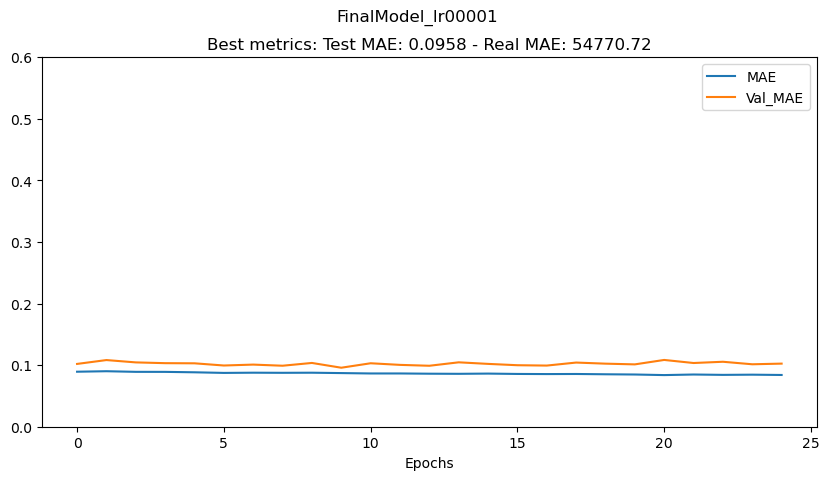

In [64]:
model = keras.models.load_model("models/" + name + ".keras") 
res = model.evaluate(testData)[1]

print_plot(name, history, f"Test MAE: {res:.4f} - " + f"Real MAE: {res*stdSales:.2f}")

The Real MAE of the model decrease from 56298.53 to 54770.72.

## 4.Results and conclusions

In this section we show the final results and we make some conclusions about the project

Basic model - Acc: 0.1185
Optimizer selection - Acc: 0.1157
Complex model - Acc: 0.0984
Complex model with regularization - Acc: 0.1087
Complex model with fine tuning - Acc: 0.0958


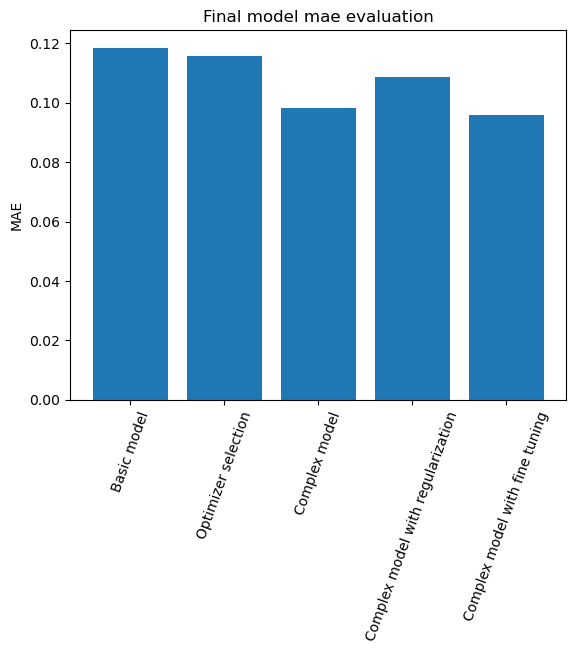

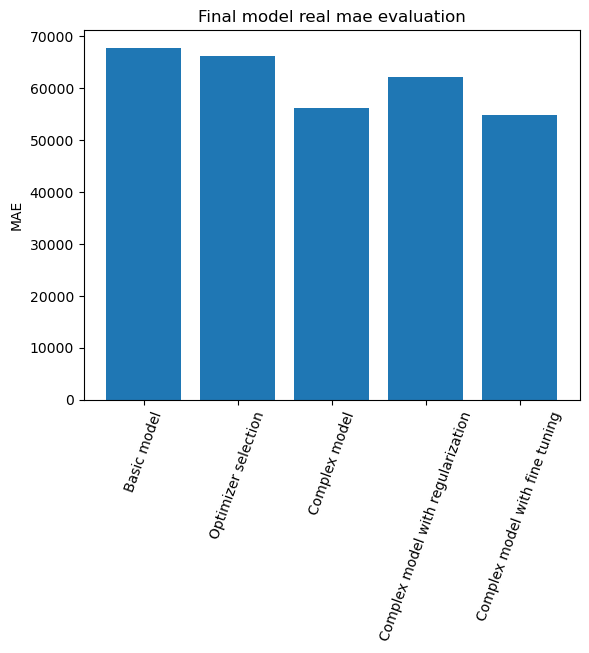

In [77]:
mae_models = [0.1185, 0.1157, 0.0984, 0.1087, 0.0958]
real_mae_models = [67778.31, 66184.13, 56298.53, 62152.80, 54770.72]
names = ["Basic model", "Optimizer selection", "Complex model", "Complex model with regularization", "Complex model with fine tuning"]

for i in range(0,len(mae_models)):
    print(names[i], '- Acc:', mae_models[i])

plt.bar(names, mae_models)
plt.title('Final model mae evaluation')
plt.ylabel('MAE')
plt.tick_params(axis='x', rotation=70)
plt.show()

plt.bar(names, real_mae_models)
plt.title('Final model real mae evaluation')
plt.ylabel('MAE')
plt.tick_params(axis='x', rotation=70)
plt.show()

In the above graphic we can see the evolution of our model thought the different steps that we set for our selection, first the test of different basic architectures, then the selection of the optimizer, the test of more complex models, the use of different regularization techniques and finally the fine tunning of our final model.

We can see how our metrics improve in each step, except in the case of the regularization, that give worst values that complex model section.

In the final execution of our model, the MAE was 0.0958 with a denormalized value of 54770.72.